# Characteristics Model
## Setup

In [14]:
import numpy as np
import torch
from torchvision import models
import torch.optim as optim
import torch.nn as nn
import torchvision.transforms as T


from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt

from train import *
from data_utils import *

%load_ext autoreload
%autoreload 2

FINAL = True

USE_GPU = True
dtype = torch.float32

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

torch.backends.cudnn.benchmark = True

print('use cuda = ', torch.cuda.is_available())
print('using device:', device)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
use cuda =  True
using device: cuda


In [2]:
## Load the data
fname = "bolete.h5"
# fname = "bolete_lowres.h5"
data = load_bolete_data(fname)

ItemsViewHDF5(<HDF5 file "bolete_lowres.h5" (mode r)>)


In [3]:
# Get Train and Test Split
X_train, X_test, Y_train, Y_test, y_train, y_test = get_train_and_test(data, 'bolete-characteristics')


In [4]:
## Download pretrained model(s)
model = models.googlenet(pretrained=True)
# model = models.resnext101_32x8d(pretrained=True)
# model = models.alexnet(pretrained=True)

## Transfer Learn with cross validation


In [5]:
def loss_fn(scores, true_y):
    probs = torch.sigmoid(scores)
    if_true = true_y * torch.log(probs)
    if_false = (1-true_y) * torch.log(1 - probs)
    loss = -1 * torch.sum(if_true + if_false)
    return loss

def pred_fn(scores):
    outputs = torch.sigmoid(scores)
    preds = outputs > 0.5
    return preds

num_classes = Y_train.shape[1]

for param in model.parameters():
    param.requires_grad = False
 
fc_in_feats = model.fc.in_features
model.fc = nn.Linear(fc_in_feats, num_classes)

# optimizer = optim.Adam(model.fc.parameters(), betas=(.5, .999), lr=1e-2)

optimizer = optim.RMSprop(
    model.parameters(),
    lr=5e-4,
    momentum=0.1,
    alpha=0.99
    )

transform = T.Compose([T.ToTensor()])

batch_size = 128
num_epochs = 40

torch.manual_seed(0)
history = cross_val(
    X_train, 
    Y_train,
    y_train,
    model, 
    optimizer, 
    # nn.MultiLabelSoftMarginLoss(), 
    nn.BCEWithLogitsLoss(),
    pred_fn,
    batch_size = batch_size, 
    num_epochs = num_epochs,
    show_every = 1,
    folds=1,
    test_size=0.2,
    device=device,
    dtype=dtype,
    transform = None,
)

CV model on:  cuda
CV Fold:  1
Training model on:  cuda
Iter: 0
train Loss: 0.6117 Acc: 25.2664
Iter: 1
val Loss: 0.5683 Acc: 26.8075
Iter: 2
train Loss: 0.5642 Acc: 26.9960
Iter: 3
val Loss: 0.5650 Acc: 26.9198
Iter: 4
train Loss: 0.5572 Acc: 27.2236
Iter: 5
val Loss: 0.5629 Acc: 26.9465
Iter: 6
train Loss: 0.5510 Acc: 27.3548
Iter: 7
val Loss: 0.5619 Acc: 26.9251
Iter: 8
train Loss: 0.5461 Acc: 27.4444
Iter: 9
val Loss: 0.5610 Acc: 26.9198
Iter: 10
train Loss: 0.5429 Acc: 27.5248
Iter: 11
val Loss: 0.5606 Acc: 26.9305
Iter: 12
train Loss: 0.5381 Acc: 27.7537
Iter: 13
val Loss: 0.5599 Acc: 26.9893
Iter: 14
train Loss: 0.5343 Acc: 27.8313
Iter: 15
val Loss: 0.5594 Acc: 27.0374
Iter: 16
train Loss: 0.5312 Acc: 27.8394
Iter: 17
val Loss: 0.5591 Acc: 27.0695
Iter: 18
train Loss: 0.5290 Acc: 27.9050
Iter: 19
val Loss: 0.5588 Acc: 27.0963
Iter: 20
train Loss: 0.5256 Acc: 27.9987
Iter: 21
val Loss: 0.5585 Acc: 27.0963
Iter: 22
train Loss: 0.5221 Acc: 28.0763
Iter: 23
val Loss: 0.5584 Acc: 27

True

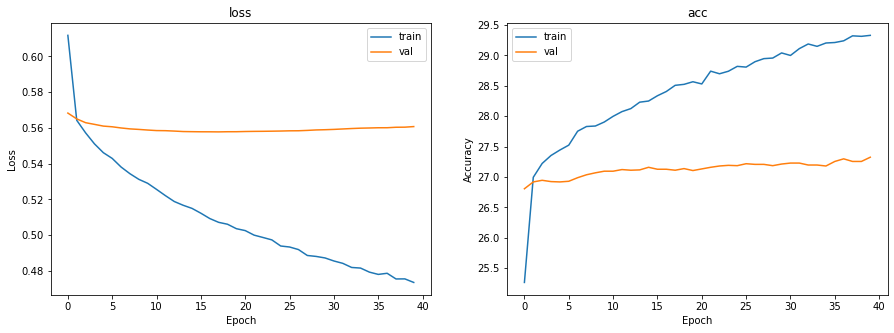

In [6]:
fig, axes = plt.subplots(1, 2, figsize=[15,5], sharex=False, sharey=False)
axes[0].set_ylabel("Loss")
axes[1].set_ylabel("Accuracy")

plotnum = 0

phase = ["train", "val"]
for s in ["loss", "acc"]:
    for a in phase:
        axes[plotnum].set_title(s)
        axes[plotnum].set_xlabel("Epoch")
        # for i in range(len(history[a+'_'+s])):
            # axes[plotnum].plot(history[a+'_'+s][i])
        axes[plotnum].plot(np.mean(history[a+'_'+s], axis=0))
        axes[plotnum].legend(phase)
    plotnum += 1

save_history_data(history, "characteristic_"+fname, edibility=False)

## Train on all the data

In [12]:
if FINAL:
    model = models.googlenet(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False
    
    fc_in_feats = model.fc.in_features
    model.fc = nn.Linear(fc_in_feats, num_classes)
    
    dataloader_tr = get_loader(X_train, Y_train, batch_size)
    dataloader_val = get_loader(X_test, Y_test, batch_size)
    dataloaders = {"train":dataloader_tr, "val":dataloader_val}
    train_acc_history, train_loss_history, val_acc_history, val_loss_history = train_model(
        model,
        optimizer,
        dataloaders,
        loss_fn,
        pred_fn,
        num_epochs,
        show_every=1,
        device=device,
        dtype=dtype,
        phases=["train", "val"],
    )
    history = {
        "train_acc": train_acc_history,
        "train_loss": train_loss_history,
        "val_acc": val_acc_history,
        "val_loss": val_loss_history,
    }
    save_history_data(history, "characteristic_"+fname, edibility=False, batch_size=1)

Training model on:  cuda
Iter: 0
train Loss: 3329.8391 Acc: 19.2923
Iter: 1
val Loss: 3315.6638 Acc: 19.5203
Iter: 2
train Loss: 3329.2347 Acc: 19.3105
Iter: 3
val Loss: 3317.1537 Acc: 19.5450
Iter: 4
train Loss: 3325.4464 Acc: 19.4090
Iter: 5
val Loss: 3318.4064 Acc: 19.6039
Iter: 6
train Loss: 3331.2186 Acc: 19.2163
Iter: 7
val Loss: 3319.0570 Acc: 19.6167
Iter: 8
train Loss: 3330.4723 Acc: 19.2548
Iter: 9
val Loss: 3319.3137 Acc: 19.6253
Iter: 10
train Loss: 3327.6136 Acc: 19.2998
Iter: 11
val Loss: 3319.4155 Acc: 19.6156
Iter: 12
train Loss: 3330.4653 Acc: 19.2687
Iter: 13
val Loss: 3319.4605 Acc: 19.6146
Iter: 14
train Loss: 3330.0824 Acc: 19.3576
Iter: 15
val Loss: 3319.4799 Acc: 19.6135
Iter: 16
train Loss: 3330.3228 Acc: 19.4208
Iter: 17
val Loss: 3319.4884 Acc: 19.6135
Iter: 18
train Loss: 3327.9330 Acc: 19.3876
Iter: 19
val Loss: 3319.4920 Acc: 19.6178
Iter: 20
train Loss: 3328.7054 Acc: 19.3116
Iter: 21
val Loss: 3319.4937 Acc: 19.6188
Iter: 22
train Loss: 3329.8586 Acc: 19.

## Evaluate 

In [13]:
if FINAL:
    X, Y, y = X_test, Y_test, y_test
else:
    X, Y, y = get_val(X_train, Y_train, y_train)

scores, y_pred, y_true, y_labels = evaluate(
    X,  # images
    Y,  # output
    y,  # labels
    model,
    Y.shape[1],
    pred_fn,
    device=device,
    transform=None,
)
save_raw_eval_data(scores, y_pred, y_true, y_labels, "characteristic_"+fname)

Evaluating model on:  cuda


True